In [ ]:
# Machine Learning with Tree-Based Models in Python
## 1. Classification and Regression Trees
## 2. The Bias-Variance Tradeoff
## 3. Bagging and Random Forests
## 4. Boosting
## 5. Model Tuning

## 1. Classification and Regression Trees

In [1]:
# Decision tree for classification

# Train your first classification tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
filename = 'https://raw.githubusercontent.com/chesterheng/ai-for-industry/main/datasets/wbc.csv'
wbc = pd.read_csv(filename)
X = wbc[['radius_mean', 'concave points_mean']]
y = wbc['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier 

SEED = 1 

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=SEED)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)
print(y_pred[0:5])


[0 0 1 1 1]


In [2]:
# Evaluate the classification tree

# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = dt.predict(X_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

Test set accuracy: 0.90


In [6]:
def plot_decision_regions(X, y, clf,
                          feature_index=None,
                          filler_feature_values=None,
                          filler_feature_ranges=None,
                          ax=None,
                          X_highlight=None,
                          res=0.02, legend=1,
                          hide_spines=True,
                          markers='s^oxv<>',
                          colors='red,blue,limegreen,gray,cyan'):
    """Plot decision regions of a classifier.

    Please note that this functions assumes that class labels are
    labeled consecutively, e.g,. 0, 1, 2, 3, 4, and 5. If you have class
    labels with integer labels > 4, you may want to provide additional colors
    and/or markers as `colors` and `markers` arguments.
    See http://matplotlib.org/examples/color/named_colors.html for more
    information.

    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Feature Matrix.
    y : array-like, shape = [n_samples]
        True class labels.
    clf : Classifier object.
        Must have a .predict method.
    feature_index : array-like (default: (0,) for 1D, (0, 1) otherwise)
        Feature indices to use for plotting. The first index in
        `feature_index` will be on the x-axis, the second index will be
        on the y-axis.
    filler_feature_values : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted.
    filler_feature_ranges : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted. Will use the
        ranges provided to select training samples for plotting.
    ax : matplotlib.axes.Axes (default: None)
        An existing matplotlib Axes. Creates
        one if ax=None.
    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
        An array with data points that are used to highlight samples in `X`.
    res : float or array-like, shape = (2,) (default: 0.02)
        Grid width. If float, same resolution is used for both the x- and
        y-axis. If array-like, the first item is used on the x-axis, the
        second is used on the y-axis. Lower values increase the resolution but
        slow down the plotting.
    hide_spines : bool (default: True)
        Hide axis spines if True.
    legend : int (default: 1)
        Integer to specify the legend location.
        No legend if legend is 0.
    markers : str (default 's^oxv<>')
        Scatterplot markers.
    colors : str (default 'red,blue,limegreen,gray,cyan')
        Comma separated list of colors.

    Returns
    ---------
    ax : matplotlib.axes.Axes object

    """

    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    dim = X.shape[1]

    if ax is None:
        ax = plt.gca()

    if isinstance(res, float):
        xres, yres = res, res
    else:
        try:
            xres, yres = res
        except ValueError:
            raise ValueError('Unable to unpack res. Expecting '
                             'array-like input of length 2.')

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    if feature_index is not None:
        # Unpack and validate the feature_index values
        if dim == 1:
            raise ValueError(
                'feature_index requires more than one training feature')
        try:
            x_index, y_index = feature_index
        except ValueError:
            raise ValueError(
                'Unable to unpack feature_index. Make sure feature_index '
                'only has two dimensions.')
        try:
            X[:, x_index], X[:, y_index]
        except IndexError:
            raise IndexError(
                'feature_index values out of range. X.shape is {}, but '
                'feature_index is {}'.format(X.shape, feature_index))
    else:
        feature_index = (0, 1)
        x_index, y_index = feature_index

    # Extra input validation for higher number of training features
    if dim > 2:
        if filler_feature_values is None:
            raise ValueError('Filler values must be provided when '
                             'X has more than 2 training features.')

        if filler_feature_ranges is not None:
            if not set(filler_feature_values) == set(filler_feature_ranges):
                raise ValueError(
                    'filler_feature_values and filler_feature_ranges must '
                    'have the same keys')

        # Check that all columns in X are accounted for
        column_check = np.zeros(dim, dtype=bool)
        for idx in filler_feature_values:
            column_check[idx] = True
        for idx in feature_index:
            column_check[idx] = True
        if not all(column_check):
            missing_cols = np.argwhere(~column_check).flatten()
            raise ValueError(
                'Column(s) {} need to be accounted for in either '
                'feature_index or filler_feature_values'.format(missing_cols))

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = X[:, x_index].min() - 1, X[:, x_index].max() + 1
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = X[:, y_index].min() - 1, X[:, y_index].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, xres),
                         np.arange(y_min, y_max, yres))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = filler_feature_values[feature_idx]
    Z = clf.predict(X_predict)
    Z = Z.reshape(xx.shape)
    # Plot decisoin region
    ax.contourf(xx, yy, Z,
                alpha=0.3,
                colors=colors,
                levels=np.arange(Z.max() + 2) - 0.5)

    ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())

    # Scatter training data samples
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   alpha=0.8,
                   c=colors[idx],
                   marker=next(marker_gen),
                   edgecolor='black',
                   label=c)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if legend:
        if dim > 2 and filler_feature_ranges is None:
            pass
        else:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels,
                      framealpha=0.3, scatterpoints=1, loc=legend)

    if plot_testdata:
        if dim == 1:
            x_data = X_highlight
            y_data = [0 for i in X_highlight]
        elif dim == 2:
            x_data = X_highlight[:, x_index]
            y_data = X_highlight[:, y_index]
        else:
            feature_range_mask = get_feature_range_mask(
                    X_highlight, filler_feature_values=filler_feature_values,
                    filler_feature_ranges=filler_feature_ranges)
            y_data = X_highlight[feature_range_mask, y_index]
            x_data = X_highlight[feature_range_mask, x_index]

        ax.scatter(x_data,
                   y_data,
                   c='',
                   edgecolor='black',
                   alpha=1.0,
                   linewidths=1,
                   marker='o',
                   s=80)

    return ax

In [7]:
def plot_labeled_decision_regions(X,y, models):    
    '''
    Function producing a scatter plot of the instances contained 
    in the 2D dataset (X,y) along with the decision 
    regions of two trained classification models contained in the
    list 'models'.
            
    Parameters
    ----------
    X: pandas DataFrame corresponding to two numerical features 
    y: pandas Series corresponding the class labels
    models: list containing two trained classifiers 
    
    '''
    if len(models) != 2:
        raise Exception('''
        Models should be a list containing only two trained classifiers.
        ''')
    if not isinstance(X, pd.DataFrame):
        raise Exception('''
        X has to be a pandas DataFrame with two numerical features.
        ''')
    if not isinstance(y, pd.Series):
        raise Exception('''
        y has to be a pandas Series corresponding to the labels.
        ''')
    fig, ax = plt.subplots(1, 2, figsize=(6.0,2.7), sharey=True)
    for i, model in enumerate(models):
        plot_decision_regions(X.values,y.values, model, legend= 2, ax = ax[i])
        ax[i].set_title(model.__class__.__name__)
        ax[i].set_xlabel(X.columns[0])
        if i == 0:
            ax[i].set_ylabel(X.columns[1])
        ax[i].set_ylim(X.values[:,1].min(), X.values[:,1].max())
        ax[i].set_xlim(X.values[:,0].min(), X.values[:,0].max())
    plt.tight_layout()
    plt.show()

In [9]:
# Logistic regression vs classification tree

# Import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression

# Instatiate logreg
logreg = LogisticRegression(solver = 'liblinear', random_state=1)

# Fit logreg to the training set
logreg.fit(X_train, y_train)

# Define a list called clfs containing the two classifiers logreg and dt
clfs = [logreg, dt]

# Review the decision regions of the two classifiers
# plot_labeled_decision_regions(X_test, y_test, clfs)

In [ ]:
# Classification tree Learning

**Growing a classification tree**

In the video, you saw that the growth of an unconstrained classification tree followed a few simple rules. Which of the following is not one of these rules?

**Possible Answers**

- [ ] The existence of a node depends on the state of its predecessors.
- [ ] The impurity of a node can be determined using different criteria such as entropy and the gini-index.
- [ ] When the information gain resulting from splitting a node is null, the node is declared as a leaf.
- [x] When an internal node is split, the split is performed in such a way so that information gain is minimized.

In [12]:
# Using entropy as a criterion

X = wbc[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']]
y = wbc['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth = 8, criterion='entropy', random_state=1)

# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth = 8, criterion='gini', random_state=1)

# Fit dt_gini to the training set
dt_gini.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [13]:
# Entropy vs Gini index

# Import accuracy_score from sklearn.metrics
from sklearn.metrics import accuracy_score

# Use dt_entropy to predict test set labels
y_pred = dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)

# Print accuracy_entropy
print('Accuracy achieved by using entropy: ', accuracy_entropy)

# Use dt_entropy to predict test set labels
y_pred = dt_gini.predict(X_test)

# Evaluate accuracy_gini
accuracy_gini = accuracy_score(y_test, y_pred)

# Print accuracy_gini
print('Accuracy achieved by using the gini index: ', accuracy_gini)

Accuracy achieved by using entropy:  0.9122807017543859
Accuracy achieved by using the gini index:  0.9035087719298246


In [15]:
# Decision tree for regression

# Train your first regression tree

import numpy as np
import pandas as pd

filename = 'https://raw.githubusercontent.com/chesterheng/ai-for-industry/main/datasets/auto.csv'
auto = pd.read_csv(filename)
auto_origin = pd.get_dummies(auto.origin)
auto = pd.concat([auto, auto_origin], axis = 1).drop('origin', axis = 1)
auto.columns = ['mpg', 'displ', 'hp', 'weight', 'accel', 'size', 'origin_Asia', 'origin_Europe', 'origin_US']

X = auto[['displ', 'hp', 'weight', 'accel', 'size', 'origin_Asia', 'origin_Europe', 'origin_US']]
y = auto['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.13, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=3, splitter='best')

In [16]:
# Evaluate the regression tree

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = (mse_dt)**0.5

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

Test set RMSE of dt: 3.66


In [18]:
# Linear regression vs regression tree

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict test set labels 
y_pred_lr = lr.predict(X_test)

# Compute mse_lr
mse_lr = MSE(y_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))

Linear Regression test set RMSE: 3.69
Regression Tree test set RMSE: 3.66


## 2. The Bias-Variance Tradeoff

In [ ]:
# Generalization Error

**Complexity, bias and variance**

In the video, you saw how the complexity of a model labeled f influences the bias and variance terms of its generalization error.

Which of the following correctly describes the relationship between f's complexity and f's bias and variance terms?

**Possible Answers**

- [ ] As the complexity of f decreases, the bias term decreases while the variance term increases.
- [ ] As the complexity of f decreases, both the bias and the variance terms increase.
- [ ] As the complexity of f increases, the bias term increases while the variance term decreases.
- [x] As the complexity of f increases, the bias term decreases while the variance term increases.


**Overfitting and underfitting**

In this exercise, you'll visually diagnose whether a model is overfitting or underfitting the training set.

For this purpose, we have trained two different A and B models  and on the auto dataset to predict the mpg consumption of a car using only the car's displacement (displ) as a feature.

The following figure shows you scatterplots of mpg versus displ along with lines corresponding to the training set predictions of models A and B in red.

![](https://raw.githubusercontent.com/chesterheng/ai-for-industry/main/images/Overfitting-and-underfitting.jpg)

Which of the following statements is true?

Possible Answers

- [ ] A suffers from high bias and overfits the training set.
Overfitting-and-underfitting.jpg
- [ ] A suffers from high variance and underfits the training set.
- [x] B suffers from high bias and underfits the training set.
- [ ] B suffers from high variance and underfits the training set.
press


In [19]:
# Diagnose bias and variance problems

# Instantiate the model

# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Set SEED for reproducibility
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Instantiate a DecisionTreeRegressor dt
dt = DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 0.26, random_state=SEED)

In [20]:
# Evaluate the 10-fold CV error

from sklearn.model_selection import cross_val_score

# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 5.14


In [21]:
# Evaluate the training error

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(0.5)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 5.15


**High bias or high variance?**

In this exercise you'll diagnose whether the regression tree dt you trained in the previous exercise suffers from a bias or a variance problem.

The training set RMSE (RMSE_train) and the CV RMSE (RMSE_CV) achieved by dt are available in your workspace. In addition, we have also loaded a variable called baseline_RMSE which corresponds to the root mean-squared error achieved by the regression-tree trained with the disp feature only (it is the RMSE achieved by the regression tree trained in chapter 1, lesson 3). Here baseline_RMSE serves as the baseline RMSE above which a model is considered to be underfitting and below which the model is considered 'good enough'.

Does dt suffer from a high bias or a high variance problem?

**Possible Answers**

- [ ] dt suffers from high variance because RMSE_CV is far less than RMSE_train.
- [x] dt suffers from high bias because RMSE_CV = RMSE_train and both scores are greater than baseline_RMSE.
- [ ] dt is a good fit because RMSE_CV = RMSE_train and both scores are smaller than baseline_RMSE

In [23]:
# Ensemble Learning

# Define the ensemble

filename = 'https://raw.githubusercontent.com/chesterheng/ai-for-industry/main/datasets/indian_liver_patient_preprocessed.csv'
liver = pd.read_csv(filename, index_col = 0)

X = liver.drop('Liver_disease', axis = 1)
y = liver['Liver_disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

from sklearn.neighbors import KNeighborsClassifier as KNN
# Set seed for reproducibility
SEED=1

# Instantiate lr
lr = LogisticRegression(random_state=SEED, solver = 'liblinear')

# Instantiate knn
knn = KNN(n_neighbors=27)

# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

In [24]:
# Evaluate individual classifiers

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train, y_train)
   
    # Predict y_pred
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy =accuracy_score(y_test, y_pred)
   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 0.764
K Nearest Neighbours : 0.701
Classification Tree : 0.730


In [25]:
# Better performance with a Voting Classifier

# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.770


## 3. Bagging and Random Forests

In [26]:
# Bagging

# Define the bagging classifier

# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)

In [27]:
# Evaluate Bagging performance

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
acc_test = accuracy_score(y_test, y_pred)
print('Test set accuracy of bc: {:.2f}'.format(acc_test))

Test set accuracy of bc: 0.69


In [28]:
# Out of Bag Evaluation

# Prepare the ground

# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=1)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, 
            n_estimators=50,
            oob_score=True,
            random_state=1)

In [29]:
# OOB Score vs Test Set Score

# Fit bc to the training set 
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate test set accuracy
acc_test = accuracy_score(y_test, y_pred)

# Evaluate OOB accuracy
acc_oob = bc.oob_score_

# Print acc_test and acc_oob
print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

Test set accuracy: 0.718, OOB accuracy: 0.686


In [30]:
# Random Forests (RF)

# Train an RF regressor

filename = 'https://raw.githubusercontent.com/chesterheng/ai-for-industry/main/datasets/bikes.csv'
bike = pd.read_csv(filename)
X = bike[['hr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'instant',
       'mnth', 'yr', 'Clear to partly cloudy', 'Light Precipitation', 'Misty']]
y = bike['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [31]:
# Evaluate the RF regressor

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = (MSE(y_test, y_pred))**0.5

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 51.84


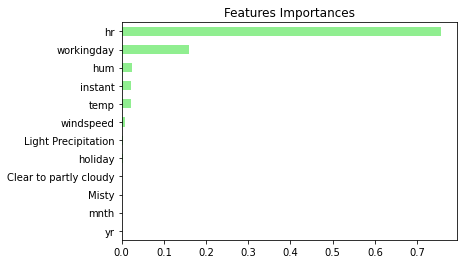

In [32]:
# Visualizing features importances

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind = 'barh', color = 'lightgreen')
plt.title('Features Importances')
plt.show()

## 4. Boosting

In [33]:
# Adaboost

# Define the AdaBoost classifier

# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

# Instantiate dt
dt = DecisionTreeClassifier(max_depth = 2, random_state=1)

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)

In [34]:
# Train the AdaBoost classifier

X = liver.drop('Liver_disease', axis = 1)
y = liver['Liver_disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:, 1]

In [35]:
# Evaluate the AdaBoost classifier

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.64


In [36]:
# Gradient Boosting (GB)

# Define the GB regressor

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor 

# Instantiate gb
gb = GradientBoostingRegressor(max_depth = 4, 
            n_estimators = 200,
            random_state=2)

In [37]:
# Train the GB regressor

X = bike[['hr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'instant',
       'mnth', 'yr', 'Clear to partly cloudy', 'Light Precipitation', 'Misty']]
y = bike['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

In [38]:
# Evaluate the GB regressor

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test ** 0.5

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 43.113


In [39]:
# Stochastic Gradient Boosting (SGB)

# Regression with SGB

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate sgbr
sgbr = GradientBoostingRegressor(max_depth=4, 
            subsample=0.9,
            max_features=0.75,
            n_estimators=200,                                
            random_state=2)

In [40]:
# Train the SGB regressor

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred = sgbr.predict(X_test)

In [41]:
# Evaluate the SGB regressor

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute test set MSE
mse_test = MSE(y_test, y_pred)

# Compute test set RMSE
rmse_test = mse_test ** 0.5

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 45.143


## 5. Model Tuning

In [ ]:
# Tuning a CART's Hyperparameters

**Tree hyperparameters**

In the following exercises you'll revisit the Indian Liver Patient dataset which was introduced in a previous chapter.

Your task is to tune the hyperparameters of a classification tree. Given that this dataset is imbalanced, you'll be using the ROC AUC score as a metric instead of accuracy.

We have instantiated a DecisionTreeClassifier and assigned to dt with sklearn's default hyperparameters. You can inspect the hyperparameters of dt in your console.

Which of the following is not a hyperparameter of dt?

**Possible Answers**

- [ ] min_impurity_decrease
- [ ] min_weight_fraction_leaf
- [x] min_features
- [ ] splitter

In [42]:
# Set the tree's hyperparameter grid

# Define params_dt
params_dt = {'max_depth': [2, 3, 4], 'min_samples_leaf': [0.12, 0.14, 0.16, 0.18]}

In [44]:
# Search for the optimal tree

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1)

In [54]:
# Evaluate the optimal tree

X = liver.drop('Liver_disease', axis = 1)
y = liver['Liver_disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
grid_dt.fit(X_train, y_train)

# Import roc_auc_score from sklearn.metrics 
from sklearn.metrics import roc_auc_score

# Extract the best estimator
best_model = grid_dt.best_estimator_

# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

Test set ROC AUC score: 0.731


In [ ]:
# Tuning a RF's Hyperparameters

**Random forests hyperparameters**

In the following exercises, you'll be revisiting the Bike Sharing Demand dataset that was introduced in a previous chapter. Recall that your task is to predict the bike rental demand using historical weather data from the Capital Bikeshare program in Washington, D.C.. For this purpose, you'll be tuning the hyperparameters of a Random Forests regressor.

We have instantiated a RandomForestRegressor called rf using sklearn's default hyperparameters. You can inspect the hyperparameters of rf in your console.

Which of the following is not a hyperparameter of rf?

**Possible Answers**

- [ ] min_weight_fraction_leaf
- [ ] criterion
- [x] learning_rate
- [ ] warm_start

In [55]:
# Set the hyperparameter grid of RF

# Define the dictionary 'params_rf'
params_rf = {'n_estimators': [100, 350, 500], 'max_features': ['log2', 'auto', 'sqrt'], 'min_samples_leaf': [2, 10, 30]}

In [56]:
# Search for the optimal forest

rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

# Import GridSearchCV
from sklearn.model_selection import  GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

In [58]:
# Evaluate the optimal forest

X = bike[['hr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'instant',
       'mnth', 'yr', 'Clear to partly cloudy', 'Light Precipitation', 'Misty']]
y = bike['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
grid_rf.fit(X_train, y_train)

# Import mean_squared_error from sklearn.metrics as MSE 
from sklearn.metrics import mean_squared_error as MSE

# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   44.6s finished


Test RMSE of best model: 51.755
